In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
#get mnist data, with one_hot encoding
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
#suppress warnings
tf.logging.set_verbosity(old_v)
imgs = mnist.train.images
labels = mnist.train.labels
imgs = mnist.test.images
labels = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# learning rate
lr = 0.01

# number of traning steps
num_steps = 20000

# network parameters
n_hidden = 100
num_input = 784
num_classes = 10

num_train = mnist.train.num_examples #55,000
num_validation = mnist.validation.num_examples #5000
num_test = mnist.test.num_examples #10,000

In [4]:
def neural_network(batch_size):
    s = time.time()
    # define weights and biases
    W1 = np.random.normal(0, 0.1, (n_hidden, num_input))
    Wout = np.random.normal(0, 0.1, (num_classes, n_hidden))
    b1 = np.random.normal(0, 0.1, (n_hidden))
    bout = np.random.normal(0, 0.1, (num_classes))
    
    w2_track = np.zeros(num_steps)
    b2_track = np.zeros(num_steps)
    w1_track = np.zeros(num_steps)
    b1_track = np.zeros(num_steps)
    loss_track = np.zeros(num_steps)
    acc_track = np.zeros(num_steps)
    for i in range(num_steps):    
        st = time.time()
        cost = 0 
        bw2 = 0
        bb2 = 0
        bw1 = 0 
        bb1 = 0 
        acc = 0 
        
        # forward propagation
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        for j in range(batch_size):
            layer_1 = W1.dot(batch_x[j]) + b1
            ReLu = np.maximum(layer_1, 0)
            output = np.matmul(Wout, ReLu) + bout
            softmax = np.exp(output)/np.sum(np.exp(output))
        
            # compute loss
            p = np.clip(softmax, 1e-20, (1. - 1e-20))
            loss = -np.sum(batch_y[j] * np.log(p)) 
            
            acc += (np.argmax(softmax) == np.argmax(batch_y[j]))
            
            # backward propagation 
            bw2 += (softmax - batch_y[j]).reshape(num_classes,1).dot(ReLu.reshape(1, n_hidden))
            bb2 += (softmax - batch_y[j])

            bb1 +=  (softmax - batch_y[j]).dot(Wout).dot(np.diag(np.sign(ReLu)))
            bw1 += bb1.reshape(n_hidden,1).dot(batch_x[j].reshape(1, num_input))
            
        bw2 = bw2 / batch_size 
        bb2 = bb2 / batch_size 
        bb1 = bb1 / batch_size 
        bw1 = bw1 / batch_size 
        loss = loss / batch_size
        acc  = acc / batch_size

        w1_track[i] =  np.abs(bw1).sum()  
        b1_track[i] =  np.abs(bb1).sum()  
        w2_track[i] =  np.abs(bw2).sum()  
        b2_track[i] =  np.abs(bb2).sum()
        
        loss_track[i] = loss
        acc_track[i] = acc
    
        Wout -= lr * bw2
        bout -= lr * bb2
        W1 -= lr * bw1
        b1 -= lr * bb1
        
    f = time.time()
    
    plt.plot(loss_track)
    plt.title('cost - iterations  with batch_size:' + str(batch_size))
     
    test_x = mnist.test.images
    test_y = mnist.test.labels

    for k in range(num_test):
        
        test_layer_1 = W1.dot(test_x[k]) + b1
        test_ReLu = np.maximum(test_layer_1, 0)
        test_output = np.matmul(Wout, test_ReLu) + bout
        test_softmax = np.exp(test_output)/np.sum(np.exp(test_output))

        test_p = np.clip(test_softmax, 1e-20, (1 - 1e-20))
        test_loss = - np.sum(test_y[k] * np.log(test_p)) / num_test
            
        acc += (np.argmax(test_softmax) == np.argmax(test_y[k]))

    acc  = acc / num_test
    
    print('Test accuracy:' + str(acc))
    print('Total training time:{:.1f}'.format(f - s))
    
    return None        

Test accuracy:0.94239375
Total training time:60.1


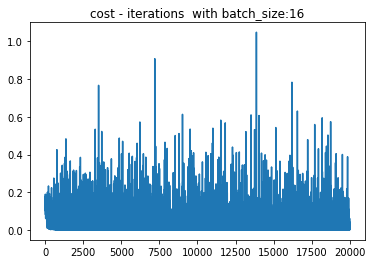

In [5]:
neural_network(16)

Test accuracy:0.9378953125
Total training time:209.8


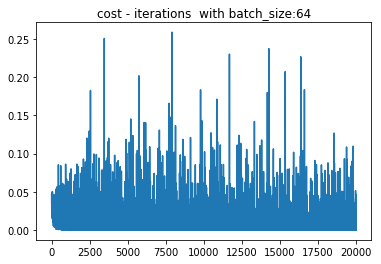

In [6]:
neural_network(64)

Test accuracy:0.93309375
Total training time:843.7


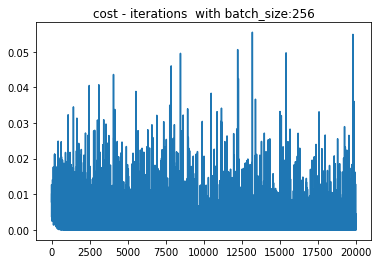

In [7]:
neural_network(256)

In [ ]:
neural_network(1024)

In [ ]:
num_steps = 5000
batch_size = 16

tf.reset_default_graph()
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden]),name='W1'),
    'Wout': tf.Variable(tf.random_normal([n_hidden, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden]),name='b1'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

#define a neural net model
def neural_net(x):
    layer_1_out = tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer_1_out = tf.sigmoid(layer_1_out)
    out = tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout'])
    return out

#predicted labels
logits = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

s = time.time()
loss_track = []
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_steps):
        #fetch batch
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})
        loss = sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
        loss_track.append(loss)
    
    f = time.time()
    
    plt.plot(loss_track)
    plt.title('cost - iterations  with batch_size:' + str(batch_size) )
    print("Training finished!")
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}))
    print('Total training time:{:.1f}'.format(f - s))

In [ ]:
num_steps = 5000
batch_size = 64

tf.reset_default_graph()
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden]),name='W1'),
    'Wout': tf.Variable(tf.random_normal([n_hidden, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden]),name='b1'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

#define a neural net model
def neural_net(x):
    layer_1_out = tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer_1_out = tf.sigmoid(layer_1_out)
    out = tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout'])
    return out

#predicted labels
logits = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

s = time.time()
loss_track = []
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_steps):
        #fetch batch
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})
        loss = sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
        loss_track.append(loss)
    
    f = time.time()
    
    plt.plot(loss_track)
    plt.title('cost - iterations  with batch_size:' + str(batch_size) )
    print("Training finished!")
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}))
    print('Total training time:{:.1f}'.format(f - s))

In [ ]:
num_steps = 5000
batch_size = 256

tf.reset_default_graph()
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden]),name='W1'),
    'Wout': tf.Variable(tf.random_normal([n_hidden, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden]),name='b1'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

#define a neural net model
def neural_net(x):
    layer_1_out = tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer_1_out = tf.sigmoid(layer_1_out)
    out = tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout'])
    return out

#predicted labels
logits = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

s = time.time()
loss_track = []
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_steps):
        #fetch batch
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})
        loss = sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
        loss_track.append(loss)
    
    f = time.time()
    
    plt.plot(loss_track)
    plt.title('cost - iterations  with batch_size:' + str(batch_size) )
    print("Training finished!")
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}))
    print('Total training time:{:.1f}'.format(f - s))

In [ ]:
num_steps = 5000
batch_size = 1024

tf.reset_default_graph()
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden]),name='W1'),
    'Wout': tf.Variable(tf.random_normal([n_hidden, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden]),name='b1'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

#define a neural net model
def neural_net(x):
    layer_1_out = tf.add(tf.matmul(x,weights['W1']),biases['b1'])
    layer_1_out = tf.sigmoid(layer_1_out)
    out = tf.add(tf.matmul(layer_1_out,weights['Wout']),biases['bout'])
    return out

#predicted labels
logits = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

s = time.time()
loss_track = []
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_steps):
        #fetch batch
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        #run optimization
        sess.run(train_op, feed_dict={X:batch_x, Y:batch_y})
        loss = sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
        loss_track.append(loss)
    
    f = time.time()
    
    plt.plot(loss_track)
    plt.title('cost - iterations  with batch_size:' + str(batch_size) )
    print("Training finished!")
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X:mnist.test.images, Y:mnist.test.labels}))
    print('Total training time:{:.1f}'.format(f - s))